In [1]:
%matplotlib inline
import sys
sys.path.insert(0, "../..")

In [2]:
import random

import deeptrack as dt
import deeptrack.extras
import numpy as np
import skimage.color
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io

deeptrack.extras.datasets.load("CellData")

CellData already downloaded! Use force_overwrite=True to redownload the dataset.


In [15]:
import numpy as np
import matplotlib.pyplot as plt

crop_size = 64
padding = 32
wavelength = 633e-9 
pixel_size = 114e-9
crop_propagation_forward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, 1e-7, pixel_size * 2, wavelength)
crop_propagation_backward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, -1e-7, pixel_size * 2, wavelength)

experimental_data = np.load(r'datasets/CellData/shifted_cell_data.npy', allow_pickle=True)
# experimental_data[..., 0] += 1

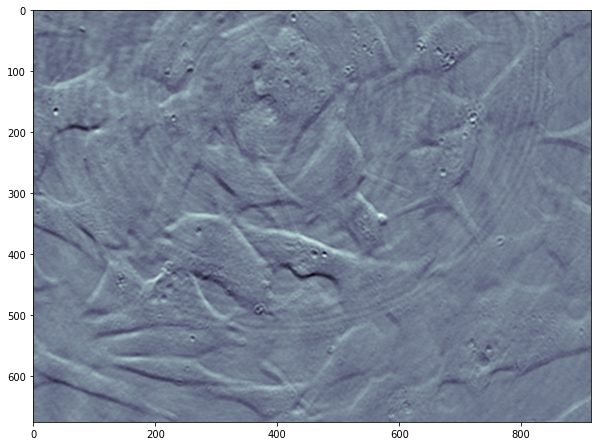

In [4]:
plt.figure(figsize=(10, 10))
plt.imshow(experimental_data[30, ..., 1], cmap="bone")

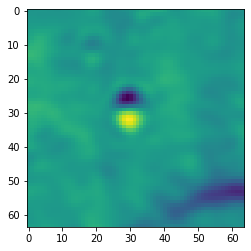

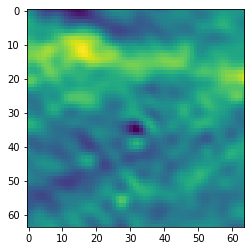

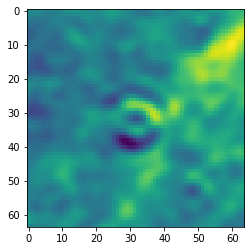

In [5]:
ds = 2
crs = 64

# Only the first crop is used in the paper.
crops = [
    (0, (310 - 32) // 2, (40 - 32) // 2),
    (30, 400, 537),
    (10, (1070 - 32) // 2, (950 - 32) // 2 ),
    
]

training_images = []

for t, x, y in crops:
    im = experimental_data[t, x:x+crs, y:y+crs]
    training_images.append(im)
    plt.imshow(im[..., 1])
    plt.show()


In [6]:
args = dt.Arguments(
    translate=lambda: np.random.randn(2) * 1,
    rotate=lambda:np.random.uniform(0, np.pi*2),
    z=lambda: np.random.uniform(-3, 3),
    rescale=lambda: 10**np.random.uniform(-0.8, 0.8)
)

group = ( 
     dt.Affine(rotate=args.rotate) 
    >>dt.Affine(translate=args.translate) 
    >> dt.Rescale(args.rescale) 
    >> dt.FourierTransform() 
    >> dt.FourierTransformTransformation(crop_propagation_forward, crop_propagation_backward, args.z) 
    >> dt.InverseFourierTransform() 
    >> dt.Add(lambda: np.random.randn(1, 1, 2) * 0.05)
)
group = group[8:-8, 8:-8]

equivariance = (

    dt.models.lodestar.Rotational2DEquivariance(args.rotate)
    >> dt.models.lodestar.TranslationalEquivariance(args.translate)
    
    # >> dt.models.lodestar.Equivariance(1, args.z / 10, indexes=2)
    >> dt.models.lodestar.Equivariance(1, lambda arg: np.log(arg), arg = args.rescale, indexes=2)
)

In [7]:
import random
training_set = dt.Value(lambda: np.array(random.choice(training_images)))
generator = dt.models.lodestar.LodeSTARGenerator(
    training_set,
    3,
    (group, equivariance), 
    batch_size=8, 
    min_data_size=400, 
    max_data_size=401
)



In [8]:

with generator:
    model = dt.models.LodeSTAR(input_shape=(None, None, 2), num_outputs=3)
    model.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())
    model.fit(generator, epochs=30, steps_per_epoch=100)


Generating 401 / 400 samples before starting training
Epoch 1/50
100/100 [==============================] - 3s 12ms/step - total_loss: 2.6042 - consistency_loss: 1.8229
Epoch 2/50
100/100 [==============================] - 1s 11ms/step - total_loss: 2.1614 - consistency_loss: 1.3661
Epoch 3/50
100/100 [==============================] - 1s 11ms/step - total_loss: 2.1550 - consistency_loss: 1.2812
Epoch 4/50
100/100 [==============================] - 1s 11ms/step - total_loss: 1.7386 - consistency_loss: 1.0612
Epoch 5/50
100/100 [==============================] - 1s 11ms/step - total_loss: 1.3791 - consistency_loss: 0.7745
Epoch 6/50
100/100 [==============================] - 1s 11ms/step - total_loss: 1.3914 - consistency_loss: 0.7619
Epoch 7/50
100/100 [==============================] - 1s 13ms/step - total_loss: 0.6664 - consistency_loss: 0.2826
Epoch 8/50
100/100 [==============================] - 1s 11ms/step - total_loss: 0.5458 - consistency_loss: 0.1967
Epoch 9/50
100/100 [======

KeyboardInterrupt: 

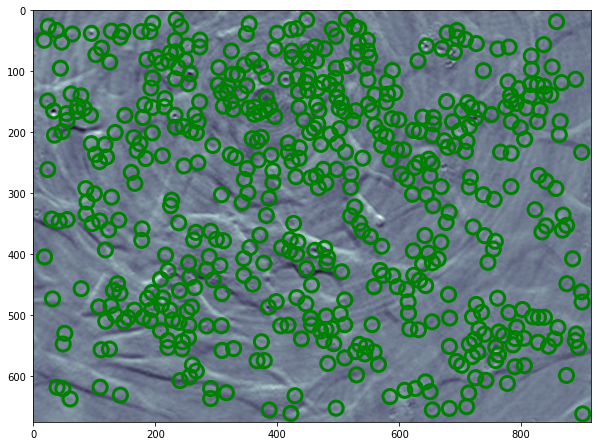

In [10]:
exp_data = experimental_data
dets = model.predict_and_detect(exp_data, alpha=.05, beta=.95, cutoff=1, mode="constant")

plt.figure(figsize=(10, 10))
plt.imshow(exp_data[0, ..., 1], cmap="bone")
plt.scatter(dets[0][:, 1], dets[0][:, 0], s=200, facecolor="none", linewidths=3, edgecolors="g")
plt.show()


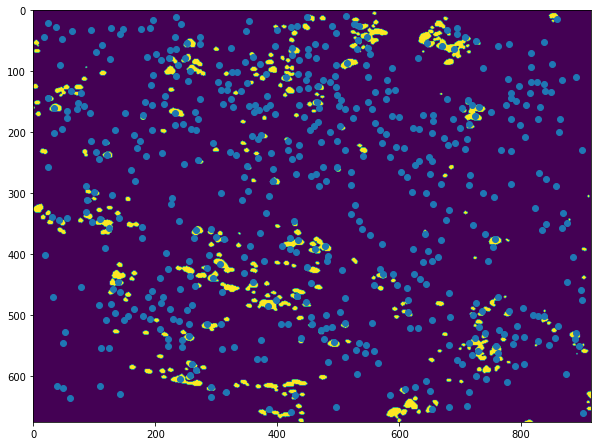

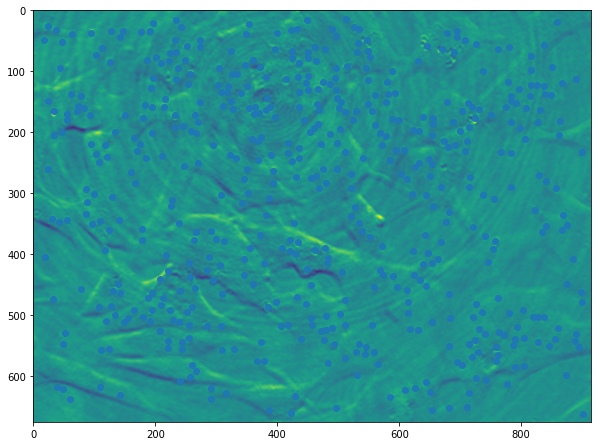

In [11]:
fluo = np.load(r"datasets/CellData/cell_fluo_mask.npy")


t = 0

plt.figure(figsize=(10, 10))
plt.imshow(fluo[t])
plt.scatter(dets[t][:,1]*1, dets[t][:, 0]*1.005 - 5)
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(exp_data[t,...,1])
plt.scatter(dets[t][:,1], dets[t][:, 0])
plt.show()
# plt.imshow(exp_data[1, ..., 1])
# plt.show()

In [ ]:

traces = []
for idx in range(len(dets)):

    connections = []
    connected_observations = []
    # Trace doroplets
    for idy, trace in enumerate(traces):

        last_frame, *pos = trace[-1]
        if idx - last_frame > 4:
            continue

        for idz, new_pos in enumerate(dets[idx]):
            distance = np.sqrt(np.square(new_pos[:2] - pos[:2]).sum())
            
            if (
                distance < 5 and idz not in connected_observations
            ):
                connected_observations.append(idz)
                trace.append(np.array((idx, *new_pos)))

    detections = [p for i, p in enumerate(dets[idx]) if i not in connected_observations]

    # Initiate new traces
    for det in detections:
        traces.append([np.array((idx, *det))])

# traces = list(filter(lambda t: len(t) > , traces))

len(traces)

11842

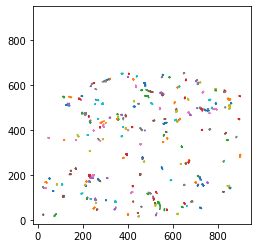

In [ ]:
_traces = list(map(np.array, traces))
_traces = list(filter(lambda t: len(t) > 10, _traces))
for trace in _traces:
    plt.plot(trace[:, 2], trace[:, 1])
plt.axis("square")
plt.show()


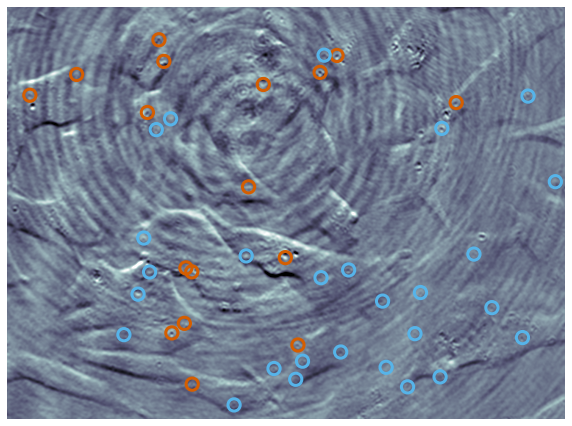

In [ ]:
import seaborn
cl = []
for d in _traces:
    s = 0
    for _d in d:
        t, x, y =_d[0], _d[1]*1.005 - 5, _d[2]
        try:
            s += np.max(fluo[int(t), int(x)-0:int(x)+1, int(y)-0:int(y)+1])
        except ValueError:
            pass
    s /= len(d)
    if s > 0.5:
        cl.append(1)
    else:
        cl.append(0)

from IPython import display

c1 = seaborn.color_palette("colorblind")[3]
c2 = seaborn.color_palette("colorblind")[9]
for t, frame in enumerate(exp_data):
    if t % 10:
        continue
    plt.figure(figsize=(10, 10))
    plt.imshow(exp_data[t, :, :, 1], cmap="bone", vmin=-1, vmax=1)
    plt.axis("off")
    
    for j, (trace, c) in enumerate(zip(_traces, cl)):
        trace = np.array(trace)
        if np.any(trace[:, 0] == t):
            sub_trace = trace[(trace[:, 0] > t - 100) & (trace[:, 0] <= t)]
            
            plt.scatter(sub_trace[-1, 2], sub_trace[-1, 1], s=150, facecolor="none", linewidths=3, edgecolors=c1 if c else c2)
    display.clear_output(wait=True)
    plt.show()

([], [])

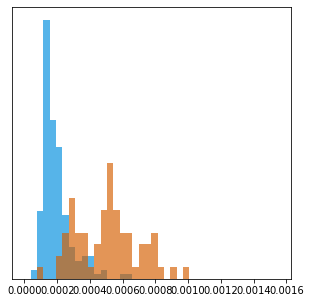

In [ ]:
out = np.zeros((0,))
outa = np.zeros((0,))
outb = np.zeros((0,))
for d in _traces:

    s = 0
    for _d in d:
        t, x, y =_d[0], _d[1]*1.005 - 5, _d[2]
        try:
            s += np.max(fluo[int(t), int(x):int(x)+1, int(y):int(y)+1])
        except ValueError:
            pass
    s /= len(d)
    vals = dt.convolve(d[:, 3], np.ones((25,))/25)[::25]
    if s== 1:
        outa = np.concatenate((outa, vals), axis=0)
    elif s == 0:
        outb = np.concatenate((outb, vals), axis=0)

    out = np.concatenate((out, vals), axis=0)


import seaborn

ps_in_cell = 0.228**3*(1.58 - 1.39) / (1.39 * 2 + 1.58)
ps_in_water = 0.228**3*(1.58 - 1.393) / (1.33* 2 + 1.58)

# In the paper, we used a separate calibration set
norm_factor = ps_in_cell / np.median(np.exp(outa))

plt.figure(figsize=(5, 5))

plt.hist(np.exp(outb) * norm_factor, 40, range=(0, ps_in_cell * 3), density=True, alpha=1, color=seaborn.color_palette("colorblind")[9], edgecolor="none")
plt.hist(np.exp(outa) * norm_factor, 40, range=(0, ps_in_cell * 3), density=True, alpha=0.66, color=seaborn.color_palette("colorblind")[3], edgecolor="none")
plt.yticks([])